In [1]:
%pip install tensorflow tf2onnx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 377.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 1.4 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tf2onnx
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_dir = './dataset'

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

Found 4 images belonging to 2 classes.


In [16]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

/var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/ipykernel_37178/3358278115.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [18]:
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6618
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 4.2775e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 1.9699e-05
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 3.1590e-06
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 6.5565e-07
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 9.5367e-07
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 1.7881e-07
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.9802e-08
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 2.9802e-08


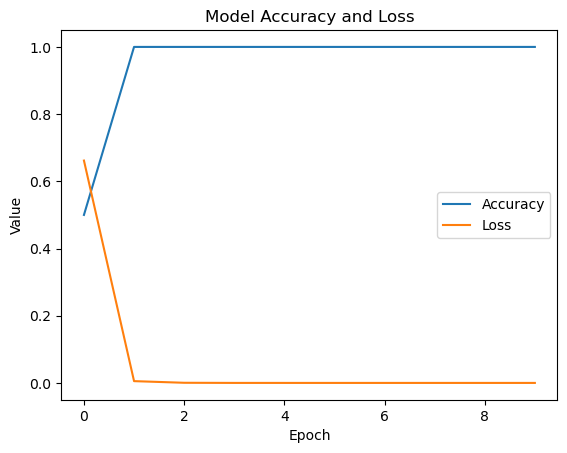

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'])
plt.show()

In [23]:
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open("clothing_classifier.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
print("✅ Model saved as clothing_classifier.onnx")

I0000 00:00:1746719976.148495 11168565 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1746719976.149326 11168565 single_machine.cc:361] Starting new session
I0000 00:00:1746719976.793877 11168565 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1746719976.793961 11168565 single_machine.cc:361] Starting new session


✅ Model saved as clothing_classifier.onnx


In [25]:
import json
import os

In [26]:
class_names = sorted(os.listdir("dataset"))  # Alphabetical class order

with open("classes.json", "w") as f:
    json.dump(class_names, f)

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os

In [31]:
class_names = sorted(os.listdir("dataset"))  # e.g. ['jeans', 'shirt', 't-shirt']

# Load and preprocess image
img_path = "dataset/shirt/1.jpeg"  # Path to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

# Make prediction
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions[0])
predicted_label = class_names[predicted_index]

print(f"Prediction: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: shirt
